**Assignment**: Designing and Tuning a Convolutional Neural Network (CNN)

**Assignment Description**: There are four parts to this assignment

1.   Building a CNN
2.   Training and Tuning a CNN
3.   Trying Out a New Dataset
4.   Open-Ended Exploration

You will be largely guided through the first two parts. The third and fourth part are discussion based questions. 

**Before the experiment, make sure that you have GPU enabled. This setting can be found under *Tools --> Settings***

In [2]:
#Install Objax
!pip --quiet install  objax
import objax

In [4]:
import tensorflow as tf 
import tensorflow_datasets as tfds
import numpy as np
import jax.numpy as jn
import random 
import matplotlib.pyplot as plt

## **Part 1. Building a CNN** 

Before we build our CNN model, let's first import a dataset. For our experiment, we load the CIFAR10 dataset from Tensorflow's dataset repository. The CIFAR10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6000 images per class. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

After loading the dataset, we split the dataset into training, validation and test set. The dataset is originally stored as 50,000 training examples and 10,000 test examples. Instead, we will combine them together and make our own split.

Do not change split ratio for now.

In [7]:
#.load_data() by default returns a split between training and test set. 
# We then adjust the training set into a format that can be accepted by our CNN
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.transpose(0, 3, 1, 2) / 255.0
Y_train = Y_train.flatten()
X_test = X_test.transpose(0, 3, 1, 2) / 255.0
Y_test = Y_test.flatten()

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset 
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data = np.concatenate([X_train, X_test], axis = 0)
Y_data = np.concatenate([Y_train, Y_test], axis = 0)

N = np.arange(len(X_data))
np.random.shuffle(N)
X_data = X_data[N]
Y_data = Y_data[N]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio = 0.80
valid_ratio = 0.1
n_train = int(len(X_data) * train_ratio)
n_valid = int(len(X_data) * valid_ratio)

X_train, X_valid, X_test = X_data[:n_train], X_data[n_train:n_train+n_valid], X_data[n_train+n_valid:]
Y_train, Y_valid, Y_test = Y_data[:n_train], Y_data[n_train:n_train+n_valid], Y_data[n_train+n_valid:]


Next we will construct a **Base Model**, which in our case is a small CNN.

In [8]:
class ConvNet(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model = ConvNet()
#You can examine the architecture of our CNN by calling model.vars()

Before we train our conv net, let's try to better understand concepts of convolution filter and linear layer. In the following, you will take the first very image of the training set, create a simple convolution routine, and show that our own routine matches what Objax returns. 



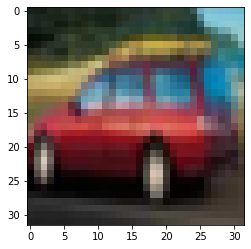

In [9]:
#Let's plot the first image in the training set.
plt.imshow(X_train[0].transpose(1,2,0))

Next, we will pass our image through Objax's convolution routine. Carefully examine the following code and try to understand the dimension of the filter weights and the output. 

In [11]:
# We append the first image with a batch size of 1 so it can be fed into a convolution layer
my_image = np.expand_dims(X_train[0], 0)

#Consider a very simple CNN filter with stride = 1 and no padding ('VALID').
Conv2d = objax.nn.Conv2D(nin = 3, nout = 2, k = 1, strides = 1, padding = 'VALID', use_bias = False)

filter_weights = Conv2d.w.value #This is the initial weight of the filter, which we gradually update when training, we ignore bias for now

# print("Conv output:", Conv2d(my_image))
# print("Conv output shape:", np.shape(Conv2d(my_image)))

**In the cells below, you will create your own convolution routine that takes in the image and the initial weights used by Objax's own convolution routine (Conv2d.w.value) and show that your convolution routine returns the same value than Objax's.**

A simple implementation only requires 4 FOR loops. You may wish to draw inspiration from https://objax.readthedocs.io/en/latest/objax/nn.html?highlight=objax.nn.Conv2D#objax.nn.Conv2D

## 2. (2 points) Fill in the code for your custom convolution filter and show that it returns the same output as Objax’s own convolution routine.

In [13]:
#Solution to the above problem
def my_conv_net(my_image, initial_filter_weights):
  initial_filter_weights = np.flipud(np.fliplr(initial_filter_weights))
  N_in, C_in, H_in, W_in = my_image.shape
  k_1, k_2, C_in, C_out = initial_filter_weights.shape
  H_out = H_in - k_1 + 1
  W_out = W_in - k_2 + 1
  my_conv_output = np.zeros([N_in, C_out , H_out, W_out])

  for n in range(my_conv_output.shape[0]):
    for c_out in range(my_conv_output.shape[1]):
      for h in range(my_conv_output.shape[2]):
        for w in range(my_conv_output.shape[3]):
          my_conv_output[n,c_out,h,w] = (jn.multiply(my_image[n, :, h, w], initial_filter_weights[:,:,:,c_out])).sum()

  return my_conv_output

# print("Conv output:", np.around(my_conv_net(my_image, filter_weights),decimals=5).shape)
# print("Conv output:", np.around(Conv2d(my_image),decimals=5).shape)

distance = np.linalg.norm(np.around(my_conv_net(my_image, filter_weights),decimals=10) -  np.around(Conv2d(my_image),decimals=10))
print(distance)

print("Customized convolution routine returns the same value as convolution routine implemented using Objax")

1.0984808e-06
Customized convolution routine returns the same value as convolution routine implemented using Objax


The outputs of last convolution layer is typically rearranged so it can be fed into a linear layer. Check that calling .mean((2,3)) rearranges the output of your convolution routine by examining the shape of the output. (Not graded) Think about alternative ways of rearranging the output from the convolution layer. 

In [14]:
#Check that .mean((2,3)) rearranges your image
my_conv_output = my_conv_net(my_image, filter_weights)
my_conv_output.mean((2,3))

array([[ 0.35491104, -0.41205541]])

Take your rearranged output and feed it into a linear layer of appropriate size. Here is an example:

```
Linear_Layer = objax.nn.Linear(N, 1)
Y = Linear_Layer(X)
```
Next, extract the weights and bias of the linear layer using 
```
Linear_Layer.w.value
Linear_Layer.b.value
```
**Using these values, write one line of code that manually implements the linear layer. Show that it provides the same value as Objax's own linear layer.** 



## 3. (1 point) Fill in the code for your linear layer, and show that it returns the same output as passing through Objax’s own linear layer.

In [16]:
np.random.seed(1)
my_conv_output = my_conv_net(my_image, filter_weights)
X=my_conv_output.mean((2,3))
Linear_Layer = objax.nn.Linear(2,1)

#PUT YOUR CODE HERE
Y = np.dot(X, Linear_Layer.w.value) + Linear_Layer.b.value
print(Y)

Y_obj = Linear_Layer(my_conv_output.mean((2,3)))
print(Y_obj)

assert(Y==Y_obj).all()
print("manually implemented linear layer shows same values as implementation using objax")

[[1.2901229]]
[[1.2901229]]
manually implemented linear layer shows same values as implementation using objax


You have now completed Part 1 of the assignment. Good job!


## **Part 2. Training and Tuning a CNN**

The following starter code trains the neural network in Part 1. However, the optimizer and batch sampling routine are left for you to implement. Complete the lines that says #PUT YOUR CODE HERE#

Afterwards, train the model, and observe the training/validation loss and accuracy plots. You should observe that the validation accuracy is low and stagnates after a few epochs.

## 1. (1 point) Complete the optimizer by using the definition of (stochastic) gradient descent: wk+1 = wk−e∇L(wk). Note that you need to update params.value, which are the values of the trainable variables of your model.

In [17]:
#Define loss function as averaged value of of cross entropies
def loss_function(x, labels):
    logit = model(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

#Define a prediction function
predict = objax.Jit(lambda x: objax.functional.softmax(model(x)), model.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv= objax.GradValues(loss_function, model.vars())

#Create an object that can be used to provide trainable variables in the model
tv = objax.ModuleList(objax.TrainRef(x) for x in model.vars().subset(objax.TrainVar))

#Training routine
def train_op(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv(x, y)   # calculate gradient and loss value "backprop"
    #next we update the trainable parameter using SGD and similar procedure

    for grad, params in zip(gradient, tv.vars()):

      params.assign(params.value - jn.multiply(grad, lr))
    
    return loss_value                      # return loss value

#make train_op (much) faster using JIT compilation
train_op = objax.Jit(train_op, gv.vars() + tv.vars())

## 2. (1 point) Complete the batch sampling code in the train function by specifying a batch of examples. You should make use the lists train indices and val indices.

In [18]:

def train(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 9e-4):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()
  return (train_acc_epoch, val_acc_epoch)


Epoch 0001  Training Loss 2.09 Validation Loss 2.08 Training Accuracy 22.18 Validation Accuracy 22.57
Epoch 0002  Training Loss 2.09 Validation Loss 2.08 Training Accuracy 22.23 Validation Accuracy 22.50
Epoch 0003  Training Loss 2.09 Validation Loss 2.08 Training Accuracy 22.21 Validation Accuracy 22.68
Epoch 0004  Training Loss 2.08 Validation Loss 2.08 Training Accuracy 22.30 Validation Accuracy 22.70
Epoch 0005  Training Loss 2.08 Validation Loss 2.08 Training Accuracy 22.32 Validation Accuracy 22.38
Epoch 0006  Training Loss 2.08 Validation Loss 2.08 Training Accuracy 22.44 Validation Accuracy 22.68
Epoch 0007  Training Loss 2.08 Validation Loss 2.08 Training Accuracy 22.34 Validation Accuracy 22.72
Epoch 0008  Training Loss 2.08 Validation Loss 2.08 Training Accuracy 22.45 Validation Accuracy 22.95
Epoch 0009  Training Loss 2.08 Validation Loss 2.07 Training Accuracy 22.66 Validation Accuracy 22.92
Epoch 0010  Training Loss 2.08 Validation Loss 2.07 Training Accuracy 22.64 Valida

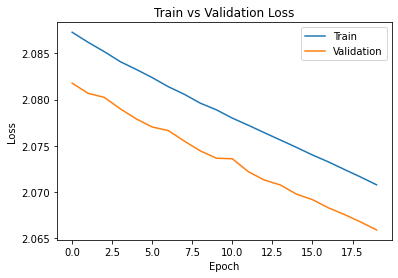

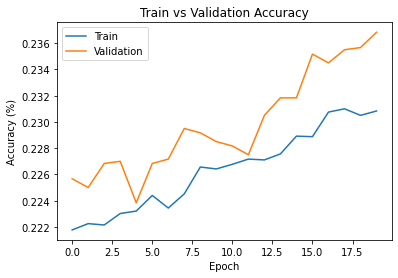

In [25]:
train_acc_base, val_acc_base = train()

In [27]:
print(np.max(train_acc_base), np.where(train_acc_base == np.max(train_acc_base))[0])
print(np.max(val_acc_base), np.where(val_acc_base == np.max(val_acc_base))[0])

0.231 [17]
0.23683333333333334 [19]


Follow the assignment handout for questions to be answered in this part of the assignment.

# 5 
# H_1 = {batch size: 32, learning rate: 0.001, optimizer: "adam", # of outputs of conv layer1: 16} 
# H_2 = {batch size: 64, learning rate: 0.01, optimizer: "LARS", # of outputs of conv layer1: 32} 

In [3]:

#H_1 = {batch size: 32, learning rate: 0.001, optimizer: "adam", # of outputs of conv layer1: 16} 
#H_2 = {batch size: 64, learning rate: 0.01, optimizer: "LARS", # of outputs of conv layer1: 32} 

class ConvNet_H_1(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3))
    x = self.linear(x)
    return x

class ConvNet_H_2(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 32, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(32, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3))
    x = self.linear(x)
    return x


model_H_1 = ConvNet_H_1()
model_H_2 = ConvNet_H_2()


In [20]:
#Define loss function as averaged value of of cross entropies
def loss_function_H_1(x, labels):
    logit = model_H_1(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

def loss_function_H_2(x, labels):
    logit = model_H_2(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()


#Optimizers
opt_H_1 = objax.optimizer.Adam(model_H_1.vars())
opt_H_2 = objax.optimizer.LARS(model_H_2.vars())


#Define a prediction function
predict_H_1 = objax.Jit(lambda x: objax.functional.softmax(model_H_1(x)), model_H_1.vars()) 
predict_H_2 = objax.Jit(lambda x: objax.functional.softmax(model_H_2(x)), model_H_2.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv_H_1= objax.GradValues(loss_function_H_1, model_H_1.vars())
gv_H_2= objax.GradValues(loss_function_H_2, model_H_2.vars())

#Create an object that can be used to provide trainable variables in the model
tv_H_1 = objax.ModuleList(objax.TrainRef(x) for x in model_H_1.vars().subset(objax.TrainVar))
tv_H_2 = objax.ModuleList(objax.TrainRef(x) for x in model_H_2.vars().subset(objax.TrainVar))

#Training routine
def train_op_H_1(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv_H_1(x, y)
    opt_H_1(lr,gradient)
    return loss_value           

def train_op_H_2(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv_H_2(x, y)
    opt_H_2(lr,gradient)
    return loss_value              


train_op_H_1 = objax.Jit(train_op_H_1, gv_H_1.vars() + tv_H_1.vars())
train_op_H_2 = objax.Jit(train_op_H_2, gv_H_2.vars() + tv_H_2.vars())

In [38]:

def train_H_1(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 0.001):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op_H_1(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict_H_1(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function_H_1(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict_H_1(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()
  return (train_acc_epoch, val_acc_epoch)



def train_H_2(EPOCHS = 20, BATCH = 64, LEARNING_RATE = 0.01):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op_H_2(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict_H_2(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function_H_2(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict_H_2(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()
  return (train_acc_epoch, val_acc_epoch)

Epoch 0001  Training Loss 1.60 Validation Loss 1.59 Training Accuracy 45.26 Validation Accuracy 42.43
Epoch 0002  Training Loss 1.59 Validation Loss 1.58 Training Accuracy 45.35 Validation Accuracy 43.37
Epoch 0003  Training Loss 1.59 Validation Loss 1.60 Training Accuracy 45.78 Validation Accuracy 42.13
Epoch 0004  Training Loss 1.58 Validation Loss 1.57 Training Accuracy 46.10 Validation Accuracy 43.48
Epoch 0005  Training Loss 1.58 Validation Loss 1.57 Training Accuracy 46.31 Validation Accuracy 43.07
Epoch 0006  Training Loss 1.57 Validation Loss 1.60 Training Accuracy 46.53 Validation Accuracy 42.47
Epoch 0007  Training Loss 1.57 Validation Loss 1.59 Training Accuracy 46.80 Validation Accuracy 41.80
Epoch 0008  Training Loss 1.56 Validation Loss 1.56 Training Accuracy 47.40 Validation Accuracy 44.35
Epoch 0009  Training Loss 1.56 Validation Loss 1.58 Training Accuracy 47.39 Validation Accuracy 42.82
Epoch 0010  Training Loss 1.55 Validation Loss 1.54 Training Accuracy 47.26 Valida

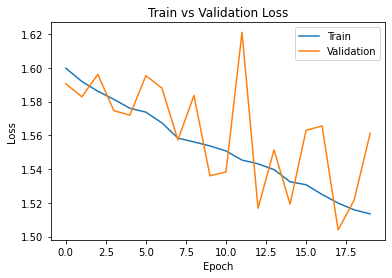

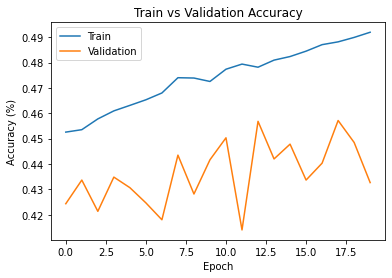

In [40]:
train_acc_H_1, val_acc_H_1 = train_H_1()

In [41]:
print(np.max(train_acc_H_1), np.where(train_acc_H_1 == np.max(train_acc_H_1))[0])
print(np.max(val_acc_H_1), np.where(val_acc_H_1 == np.max(val_acc_H_1))[0])

0.4919791666666667 [19]
0.45716666666666667 [17]


Epoch 0001  Training Loss 2.32 Validation Loss 2.32 Training Accuracy 9.87 Validation Accuracy 9.73
Epoch 0002  Training Loss 2.32 Validation Loss 2.31 Training Accuracy 9.86 Validation Accuracy 10.70
Epoch 0003  Training Loss 2.31 Validation Loss 2.31 Training Accuracy 13.12 Validation Accuracy 15.87
Epoch 0004  Training Loss 2.31 Validation Loss 2.31 Training Accuracy 14.30 Validation Accuracy 13.78
Epoch 0005  Training Loss 2.31 Validation Loss 2.30 Training Accuracy 12.94 Validation Accuracy 12.87
Epoch 0006  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 12.53 Validation Accuracy 12.53
Epoch 0007  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 12.07 Validation Accuracy 12.30
Epoch 0008  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.87 Validation Accuracy 12.30
Epoch 0009  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.75 Validation Accuracy 12.12
Epoch 0010  Training Loss 2.30 Validation Loss 2.30 Training Accuracy 11.77 Validatio

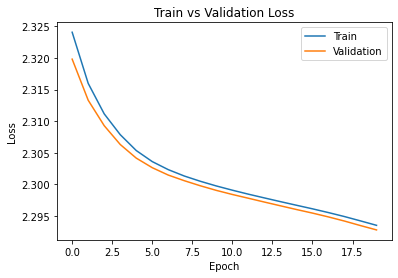

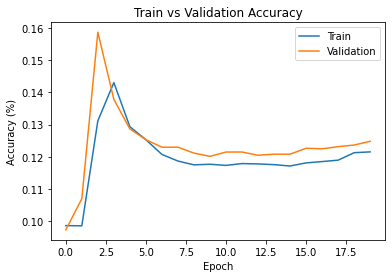

In [42]:
train_acc_H_2, val_acc_H_2 = train_H_2()

In [43]:
print(np.max(train_acc_H_2), np.where(train_acc_H_2 == np.max(train_acc_H_2))[0])
print(np.max(val_acc_H_2), np.where(val_acc_H_2 == np.max(val_acc_H_2))[0])

0.14304166666666668 [3]
0.15866666666666668 [2]


# 6.

Base Model:24% at epoch 17   

M1:46% at epoch 17 

M2: 15% at epoch 2

7. (2 points) Based on your answer, which model should you pick as your final model and
why? Then evaluate your model on the test set and report final test accuracy.

In [52]:
def eval_test_acc_base(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 0.001):
    test_acc_epoch = []
    for epoch in range(EPOCHS):
        test_acc = 0    

        # shuffle the examples prior to training to remove correlation 
        test_indices = np.arange(len(X_test)) 
        np.random.shuffle(test_indices)
        for it in range(0, X_test.shape[0], BATCH):
            batch = test_indices[it:it+BATCH]
            test_prediction = predict(X_test[batch]).argmax(1)
            test_acc += (np.array(test_prediction).flatten() == Y_test[batch]).sum()
        test_acc_epoch.append(test_acc/X_test.shape[0])
    return test_acc_epoch

def eval_test_acc_H1(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 0.001):
    test_acc_epoch = []
    for epoch in range(EPOCHS):
        test_acc = 0    

        # shuffle the examples prior to training to remove correlation 
        test_indices = np.arange(len(X_test)) 
        np.random.shuffle(test_indices)
        for it in range(0, X_test.shape[0], BATCH):
            batch = test_indices[it:it+BATCH]
            test_prediction = predict_H_1(X_test[batch]).argmax(1)
            test_acc += (np.array(test_prediction).flatten() == Y_test[batch]).sum()
        test_acc_epoch.append(test_acc/X_test.shape[0])
    return test_acc_epoch

def eval_test_acc_H2(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 0.001):
    test_acc_epoch = []
    for epoch in range(EPOCHS):
        test_acc = 0    

        # shuffle the examples prior to training to remove correlation 
        test_indices = np.arange(len(X_test)) 
        np.random.shuffle(test_indices)
        for it in range(0, X_test.shape[0], BATCH):
            batch = test_indices[it:it+BATCH]
            test_prediction = predict_H_2(X_test[batch]).argmax(1)
            test_acc += (np.array(test_prediction).flatten() == Y_test[batch]).sum()
        test_acc_epoch.append(test_acc/X_test.shape[0])
    return test_acc_epoch

test_acc_base = eval_test_acc_base()
test_acc_h_1 = eval_test_acc_H1()
test_acc_h_2 = eval_test_acc_H2()

In [53]:
print(np.max(test_acc_base))
print(np.max(test_acc_h_1))
print(np.max(test_acc_h_2))

0.22783333333333333
0.429
0.12416666666666666


We should pick model with H1 hyper parameters since it yields most accurate result among all other hyperparameter that I've declared earlier

In [ ]:
#H_1 = {batch size: 32, learning rate: 0.001, optimizer: "adam", # of outputs of conv layer1: 16} 
#H_2 = {batch size: 64, learning rate: 0.01, optimizer: "LARS", # of outputs of conv layer1: 32} 

You have now completed Part 2 of the assignment. Good job!


## **Part 3. Trying Out a New Dataset**

See the handout for instructions.


## 1. (1 point) Import and partition your data.

In [22]:
#.load_data() by default returns a split between training and test set. 
# We then adjust the training set into a format that can be accepted by our CNN
(X_train_3, Y_train_3), (X_test_3, Y_test_3) = tf.keras.datasets.fashion_mnist.load_data()
X_train_3 = X_train_3/ 255.0
Y_train_3 = Y_train_3.flatten()
X_test_3 = X_test_3/ 255.0
Y_test_3 = Y_test_3.flatten()

np.random.seed(1)
# To create a validation set, we first concate the original splitted dataset into a single dataset 
# then randomly shuffle the images and labels in the same way (seed = 1)
X_data_3 = np.concatenate([X_train_3, X_test_3], axis = 0)
Y_data_3 = np.concatenate([Y_train_3, Y_test_3], axis = 0)

N_3 = np.arange(len(X_data_3))
np.random.shuffle(N_3)
X_data_3 = X_data_3[N_3]
Y_data_3 = Y_data_3[N_3]

#Next, we partition the randomly shuffled dataset into training, validation and testset according a ratio
train_ratio_3 = 0.80
valid_ratio_3 = 0.1
n_train_3 = int(len(X_data_3) * train_ratio_3)
n_valid_3 = int(len(X_data_3) * valid_ratio_3)

X_train_3, X_valid_3, X_test_3 = np.expand_dims(X_data_3[:n_train_3],1), np.expand_dims(X_data_3[n_train_3:n_train_3+n_valid_3],1), np.expand_dims(X_data_3[n_train_3+n_valid_3:],1)
Y_train_3, Y_valid_3, Y_test_3 = Y_data_3[:n_train_3], Y_data_3[n_train_3:n_train_3+n_valid_3], Y_data_3[n_train_3+n_valid_3:]

## 2. (1 point) Create a base model to start out with

In [34]:
class ConvNet_P_3_base(objax.Module):
  def __init__(self, number_of_channels = 1, number_of_classes = 100):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3))
    x = self.linear(x)
    return x

class ConvNet_P_3_1(objax.Module):
  def __init__(self, number_of_channels = 1, number_of_classes = 100):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3))
    x = self.linear(x)
    return x
  
class ConvNet_P_3_2(objax.Module):
  def __init__(self, number_of_channels = 1, number_of_classes = 100):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 2), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 16, 2), objax.functional.relu])
    self.conv_3 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 2), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)

    x = objax.functional.max_pool_2d(self.conv_2(x), 2, 2)
    x = self.conv_3(x)
  
    x = x.mean((2,3))
    x = self.linear(x)
    return x

model_P_3_base = ConvNet_P_3_base()
model_P_3_1 = ConvNet_P_3_1()
model_P_3_2 = ConvNet_P_3_2()

## 3. (3 points) Pick several hyperparameters you would like to tune and train a model until its validation accuracy is 5-10% better than the base model. Provide a succinct discussion on your design procedure: which hyperparameters you tuned, what is the new validation accuracy.

## P_3_1 = {epoch: 50, learning rate: 0.01, # of conv layer: 2, batch_size: 32} 
## P_3_2 = {epoch: 20, learning rate: 0.001, # of conv layer: 3, batch_size: 40} 

In [35]:
#Define loss function as averaged value of of cross entropies
def loss_function_P_3_base(x, labels):
    logit = model_P_3_base(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()
    
def loss_function_P_3_1(x, labels):
    logit = model_P_3_1(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

def loss_function_P_3_2(x, labels):
    logit = model_P_3_2(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()


#Optimizers

opt_P_3_base = objax.optimizer.Adam(model_P_3_base.vars())
opt_P_3_1 = objax.optimizer.Adam(model_P_3_1.vars())
opt_P_3_2 = objax.optimizer.Adam(model_P_3_2.vars())


#Define a prediction function
predict_P_3_base = objax.Jit(lambda x: objax.functional.softmax(model_P_3_base(x)), model_P_3_base.vars()) 
predict_P_3_1 = objax.Jit(lambda x: objax.functional.softmax(model_P_3_1(x)), model_P_3_1.vars()) 
predict_P_3_2 = objax.Jit(lambda x: objax.functional.softmax(model_P_3_2(x)), model_P_3_2.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv_P_3_base= objax.GradValues(loss_function_P_3_base, model_P_3_base.vars())
gv_P_3_1= objax.GradValues(loss_function_P_3_1, model_P_3_1.vars())
gv_P_3_2= objax.GradValues(loss_function_P_3_2, model_P_3_2.vars())

#Create an object that can be used to provide trainable variables in the model
tv_P_3_base = objax.ModuleList(objax.TrainRef(x) for x in model_P_3_base.vars().subset(objax.TrainVar))
tv_P_3_1 = objax.ModuleList(objax.TrainRef(x) for x in model_P_3_1.vars().subset(objax.TrainVar))
tv_P_3_2 = objax.ModuleList(objax.TrainRef(x) for x in model_P_3_2.vars().subset(objax.TrainVar))

#Training routine
def train_op_P_3_base(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv_P_3_base(x, y)
    opt_P_3_base(lr,gradient)
    return loss_value        

def train_op_P_3_1(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv_P_3_1(x, y)
    opt_P_3_1(lr,gradient)
    return loss_value           

def train_op_P_3_2(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv_P_3_2(x, y)
    opt_P_3_2(lr,gradient)
    return loss_value              

train_op_P_3_base = objax.Jit(train_op_P_3_base, gv_P_3_base.vars() + tv_P_3_base.vars())
train_op_P_3_1 = objax.Jit(train_op_P_3_1, gv_P_3_1.vars() + tv_P_3_1.vars())
train_op_P_3_2 = objax.Jit(train_op_P_3_2, gv_P_3_2.vars() + tv_P_3_2.vars())

In [25]:
def train_P_3_base(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 0.001):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
        #   print(X_train[0].shape)
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op_P_3_base(X_train_3[batch], Y_train_3[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict_P_3_base(X_train_3[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train_3[batch]).sum()
      train_acc_epoch.append(train_acc/X_train_3.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train_3.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid_3)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid_3.shape[0], BATCH):
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function_P_3_base(X_valid_3[batch], Y_valid_3[batch])) * len(batch)
          val_prediction = predict_P_3_base(X_valid_3[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid_3[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid_3.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid_3.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()
  return (train_acc_epoch, val_acc_epoch)

def train_P_3_1(EPOCHS = 50, BATCH = 32, LEARNING_RATE = 0.01):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
        #   print(X_train[0].shape)
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op_P_3_1(X_train_3[batch], Y_train_3[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict_P_3_1(X_train_3[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train_3[batch]).sum()
      train_acc_epoch.append(train_acc/X_train_3.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train_3.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid_3)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid_3.shape[0], BATCH):
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function_P_3_1(X_valid_3[batch], Y_valid_3[batch])) * len(batch)
          val_prediction = predict_P_3_1(X_valid_3[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid_3[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid_3.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid_3.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()
  return (train_acc_epoch, val_acc_epoch)


def train_P_3_2(EPOCHS = 20, BATCH = 40, LEARNING_RATE = 0.001):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
        #   print(X_train[0].shape)
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op_P_3_2(X_train_3[batch], Y_train_3[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict_P_3_2(X_train_3[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train_3[batch]).sum()
      train_acc_epoch.append(train_acc/X_train_3.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train_3.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid_3)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid_3.shape[0], BATCH):
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function_P_3_2(X_valid_3[batch], Y_valid_3[batch])) * len(batch)
          val_prediction = predict_P_3_2(X_valid_3[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid_3[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid_3.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid_3.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()
  return (train_acc_epoch, val_acc_epoch)

Epoch 0001  Training Loss 2.13 Validation Loss 1.83 Training Accuracy 26.86 Validation Accuracy 32.56
Epoch 0002  Training Loss 1.68 Validation Loss 1.49 Training Accuracy 45.44 Validation Accuracy 51.10
Epoch 0003  Training Loss 1.40 Validation Loss 1.28 Training Accuracy 55.26 Validation Accuracy 53.97
Epoch 0004  Training Loss 1.22 Validation Loss 1.15 Training Accuracy 61.07 Validation Accuracy 58.90
Epoch 0005  Training Loss 1.12 Validation Loss 1.06 Training Accuracy 64.87 Validation Accuracy 63.84
Epoch 0006  Training Loss 1.05 Validation Loss 1.00 Training Accuracy 67.39 Validation Accuracy 66.20
Epoch 0007  Training Loss 1.00 Validation Loss 0.97 Training Accuracy 68.92 Validation Accuracy 64.51
Epoch 0008  Training Loss 0.97 Validation Loss 0.92 Training Accuracy 70.39 Validation Accuracy 68.84
Epoch 0009  Training Loss 0.94 Validation Loss 0.89 Training Accuracy 71.19 Validation Accuracy 70.04
Epoch 0010  Training Loss 0.92 Validation Loss 0.92 Training Accuracy 71.91 Valida

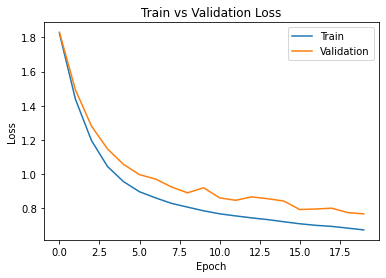

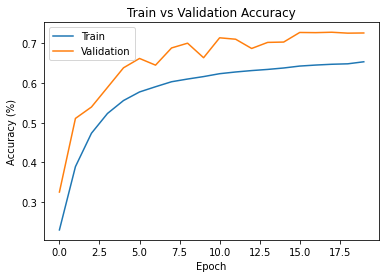

In [209]:
train_acc_P_3_base, val_acc_P_3_base = train_P_3_base()

In [ ]:
print(np.max(train_acc_P_3_base), np.where(train_acc_P_3_base == np.max(train_acc_P_3_base))[0])
print(np.max(val_acc_P_3_base), np.where(val_acc_P_3_base == np.max(val_acc_P_3_base))[0])

Epoch 0001  Training Loss 1.40 Validation Loss 1.24 Training Accuracy 53.99 Validation Accuracy 69.52
Epoch 0002  Training Loss 1.11 Validation Loss 1.15 Training Accuracy 63.19 Validation Accuracy 75.75
Epoch 0003  Training Loss 1.03 Validation Loss 1.05 Training Accuracy 68.01 Validation Accuracy 78.75
Epoch 0004  Training Loss 0.93 Validation Loss 0.99 Training Accuracy 72.98 Validation Accuracy 80.12
Epoch 0005  Training Loss 0.89 Validation Loss 0.99 Training Accuracy 75.32 Validation Accuracy 81.72
Epoch 0006  Training Loss 0.80 Validation Loss 0.90 Training Accuracy 78.04 Validation Accuracy 88.05
Epoch 0007  Training Loss 0.83 Validation Loss 1.12 Training Accuracy 77.68 Validation Accuracy 81.02
Epoch 0008  Training Loss 0.90 Validation Loss 1.08 Training Accuracy 76.59 Validation Accuracy 84.72
Epoch 0009  Training Loss 0.97 Validation Loss 0.94 Training Accuracy 75.22 Validation Accuracy 86.52
Epoch 0010  Training Loss 0.90 Validation Loss 1.01 Training Accuracy 77.71 Valida

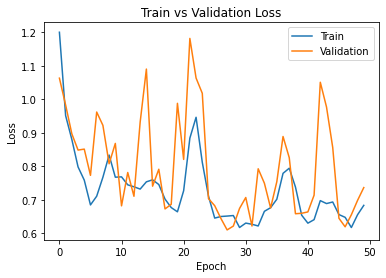

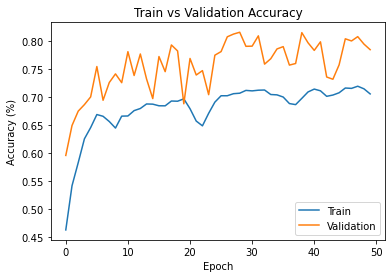

In [27]:
train_acc_P_3_1, val_acc_P_3_1 = train_P_3_1()

In [28]:
print(np.max(train_acc_P_3_1), np.where(train_acc_P_3_1 == np.max(train_acc_P_3_1))[0])
print(np.max(val_acc_P_3_1), np.where(val_acc_P_3_1 == np.max(val_acc_P_3_1))[0])

0.7195357142857143 [47]
0.816 [28]


Epoch 0001  Training Loss 1.66 Validation Loss 1.36 Training Accuracy 47.36 Validation Accuracy 61.92
Epoch 0002  Training Loss 1.07 Validation Loss 1.16 Training Accuracy 65.96 Validation Accuracy 72.10
Epoch 0003  Training Loss 0.92 Validation Loss 1.03 Training Accuracy 71.27 Validation Accuracy 77.15
Epoch 0004  Training Loss 0.82 Validation Loss 0.96 Training Accuracy 74.95 Validation Accuracy 81.07
Epoch 0005  Training Loss 0.75 Validation Loss 0.83 Training Accuracy 76.86 Validation Accuracy 86.90
Epoch 0006  Training Loss 0.72 Validation Loss 0.75 Training Accuracy 78.16 Validation Accuracy 90.38
Epoch 0007  Training Loss 0.69 Validation Loss 0.75 Training Accuracy 79.32 Validation Accuracy 88.53
Epoch 0008  Training Loss 0.66 Validation Loss 0.73 Training Accuracy 80.47 Validation Accuracy 90.87
Epoch 0009  Training Loss 0.65 Validation Loss 0.80 Training Accuracy 80.91 Validation Accuracy 86.73
Epoch 0010  Training Loss 0.62 Validation Loss 0.66 Training Accuracy 81.88 Valida

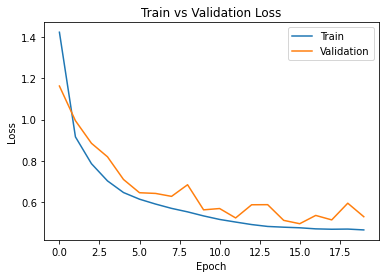

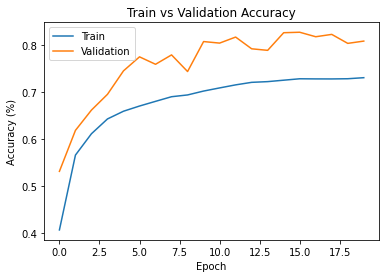

In [29]:
train_acc_P_3_2, val_acc_P_3_2 = train_P_3_2()

In [30]:
print(np.max(train_acc_P_3_2), np.where(train_acc_P_3_2 == np.max(train_acc_P_3_2))[0])
print(np.max(val_acc_P_3_2), np.where(val_acc_P_3_2 == np.max(val_acc_P_3_2))[0])

0.7303035714285714 [19]
0.8271428571428572 [15]


## 4. (1 point) Select your final model and report test accuracy.

In [39]:
def eval_test_acc_P_3(EPOCHS = 50, BATCH = 32, LEARNING_RATE = 0.001):
    test_acc_epoch = []
    for epoch in range(EPOCHS):
        test_acc = 0    

        # shuffle the examples prior to training to remove correlation 
        test_indices = np.arange(len(X_test_3)) 
        np.random.shuffle(test_indices)
        for it in range(0, X_test_3.shape[0], BATCH):
            batch = test_indices[it:it+BATCH]
            test_prediction = predict_P_3_1(X_test_3[batch]).argmax(1)
            test_acc += (np.array(test_prediction).flatten() == Y_test_3[batch]).sum()
        test_acc_epoch.append(test_acc/X_test_3.shape[0])
    return test_acc_epoch

test_acc_P_3 = eval_test_acc_P_3()

## final model:
P_3_1 = {epoch: 50, learning rate: 0.01, # of conv layer: 2, batch_size: 32} 
test_accuracy: 82%

## **Problem 4. Open-Ended Exploration**

See the handout for instructions.

## 1. Additional hyperparameter tuning

In this part of the problem I tested the impact of changing kernel size of the convolution impacting the accuracy of the model. To do this, 3 different models with differnet kernel values were used. Since I wanted to get most accurate result in this activity the knowledge of hyperparameter tuning in previous questions were used. For instance, the adam optimizer resulted in most accurate results in activity 2 so we kept this for this exercise. 

In [40]:
class ConvNet_P4_1(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 5), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 5), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

class ConvNet_P4_2(objax.Module):
  def __init__(self, number_of_channels = 3, number_of_classes = 10):
    self.conv_1 = objax.nn.Sequential([objax.nn.Conv2D(number_of_channels, 16, 7), objax.functional.relu])
    self.conv_2 = objax.nn.Sequential([objax.nn.Conv2D(16, 32, 7), objax.functional.relu])
    self.linear = objax.nn.Linear(32, number_of_classes)

  def __call__(self, x):
    x = objax.functional.max_pool_2d(self.conv_1(x), 2, 2)
    x = self.conv_2(x)
  
    x = x.mean((2,3)) #<--- global average pooling 
    x = self.linear(x)
    return x

#The following line creates the CNN
model_1 = ConvNet_P4_1()
model_2 = ConvNet_P4_2()
#You can examine the architecture of our CNN by calling model.vars()

In [41]:
#Define loss function as averaged value of of cross entropies
def loss_function_1(x, labels):
    logit = model_1(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()

def loss_function_2(x, labels):
    logit = model_2(x)
    return objax.functional.loss.cross_entropy_logits_sparse(logit, labels).mean()


#Optimizers
opt_1 = objax.optimizer.Adam(model_1.vars())
opt_2 = objax.optimizer.Adam(model_2.vars())


#Define a prediction function
predict_1 = objax.Jit(lambda x: objax.functional.softmax(model_1(x)), model_1.vars()) 
predict_2 = objax.Jit(lambda x: objax.functional.softmax(model_2(x)), model_2.vars()) 

#Create an object that can be used to calculate the gradient and value of loss_function
gv_1= objax.GradValues(loss_function_1, model_1.vars())
gv_2= objax.GradValues(loss_function_2, model_2.vars())

#Create an object that can be used to provide trainable variables in the model
tv_1 = objax.ModuleList(objax.TrainRef(x) for x in model_1.vars().subset(objax.TrainVar))
tv_2 = objax.ModuleList(objax.TrainRef(x) for x in model_2.vars().subset(objax.TrainVar))

#Training routine
def train_op_1(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv_1(x, y)
    opt_1(lr,gradient)
    return loss_value           

def train_op_2(x, y, learning_rate):
    lr = learning_rate
    gradient, loss_value = gv_2(x, y)
    opt_2(lr,gradient)
    return loss_value              


train_op_1 = objax.Jit(train_op_1, gv_1.vars() + tv_1.vars())
train_op_2 = objax.Jit(train_op_2, gv_2.vars() + tv_2.vars())

In [42]:

def train_1(EPOCHS = 50, BATCH = 32, LEARNING_RATE = 0.01):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op_1(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict_1(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function_1(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict_1(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()
  return (train_acc_epoch, val_acc_epoch)



def train_2(EPOCHS = 50, BATCH = 64, LEARNING_RATE = 0.01):
  avg_train_loss_epoch = []
  avg_val_loss_epoch = []
  train_acc_epoch = []
  val_acc_epoch = []

  for epoch in range(EPOCHS):
      avg_train_loss = 0 # (averaged) training loss per batch
      avg_val_loss =  0  # (averaged) validation loss per batch
      train_acc = 0      # training accuracy per batch
      val_acc = 0        # validation accuracy per batch

      # shuffle the examples prior to training to remove correlation 
      train_indices = np.arange(len(X_train)) 
      np.random.shuffle(train_indices)
      for it in range(0, X_train.shape[0], BATCH):
          batch = train_indices[it:it+BATCH]
          avg_train_loss += float(train_op_2(X_train[batch], Y_train[batch], LEARNING_RATE)[0]) * len(batch)
          train_prediction = predict_2(X_train[batch]).argmax(1)
          train_acc += (np.array(train_prediction).flatten() == Y_train[batch]).sum()
      train_acc_epoch.append(train_acc/X_train.shape[0])
      avg_train_loss_epoch.append(avg_train_loss/X_train.shape[0])

      # run validation
      val_indices = np.arange(len(X_valid)) 
      np.random.shuffle(val_indices)    
      for it in range(0, X_valid.shape[0], BATCH):
          batch = val_indices[it:it+BATCH]
          avg_val_loss += float(loss_function_2(X_valid[batch], Y_valid[batch])) * len(batch)
          val_prediction = predict_2(X_valid[batch]).argmax(1)
          val_acc += (np.array(val_prediction).flatten() == Y_valid[batch]).sum()
      val_acc_epoch.append(val_acc/X_valid.shape[0])
      avg_val_loss_epoch.append(avg_val_loss/X_valid.shape[0])

      print('Epoch %04d  Training Loss %.2f Validation Loss %.2f Training Accuracy %.2f Validation Accuracy %.2f' % (epoch + 1, avg_train_loss/X_train.shape[0], avg_val_loss/X_valid.shape[0], 100*train_acc/X_train.shape[0], 100*val_acc/X_valid.shape[0]))
  
  #Plot training loss
  plt.title("Train vs Validation Loss")
  plt.plot(avg_train_loss_epoch, label="Train")
  plt.plot(avg_val_loss_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc='best')
  plt.show()

  plt.title("Train vs Validation Accuracy")
  plt.plot(train_acc_epoch, label="Train")
  plt.plot(val_acc_epoch, label="Validation")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend(loc='best')
  plt.show()
  return (train_acc_epoch, val_acc_epoch)

In [43]:
train_acc_1, val_acc_1 = train_1()

Epoch 0001  Training Loss 6.35 Validation Loss 4.63 Training Accuracy 16.79 Validation Accuracy 13.63
Epoch 0002  Training Loss 4.06 Validation Loss 2.40 Training Accuracy 23.13 Validation Accuracy 22.88
Epoch 0003  Training Loss 2.53 Validation Loss 2.39 Training Accuracy 32.86 Validation Accuracy 26.18
Epoch 0004  Training Loss 2.20 Validation Loss 2.71 Training Accuracy 38.10 Validation Accuracy 26.22
Epoch 0005  Training Loss 2.29 Validation Loss 1.88 Training Accuracy 39.15 Validation Accuracy 36.57
Epoch 0006  Training Loss 2.40 Validation Loss 2.35 Training Accuracy 39.77 Validation Accuracy 30.80
Epoch 0007  Training Loss 2.52 Validation Loss 1.85 Training Accuracy 39.34 Validation Accuracy 40.85
Epoch 0008  Training Loss 2.55 Validation Loss 2.37 Training Accuracy 38.48 Validation Accuracy 32.98
Epoch 0009  Training Loss 2.56 Validation Loss 2.05 Training Accuracy 38.53 Validation Accuracy 31.88
Epoch 0010  Training Loss 2.57 Validation Loss 2.34 Training Accuracy 38.47 Valida

In [ ]:
print(np.max(train_acc_1), np.where(train_acc_1 == np.max(train_acc_1))[0])
print(np.max(val_acc_1), np.where(val_acc_1 == np.max(val_acc_1))[0])

In [ ]:
train_acc_2, val_acc_2 = train_2()

In [ ]:
print(np.max(train_acc_2), np.where(train_acc_2 == np.max(train_acc_2))[0])
print(np.max(val_acc_2), np.where(val_acc_2 == np.max(val_acc_2))[0])

In [ ]:
def eval_test_acc_1(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 0.01):
    test_acc_epoch = []
    for epoch in range(EPOCHS):
        test_acc = 0    

        # shuffle the examples prior to training to remove correlation 
        test_indices = np.arange(len(X_test)) 
        np.random.shuffle(test_indices)
        for it in range(0, X_test.shape[0], BATCH):
            batch = test_indices[it:it+BATCH]
            test_prediction = predict_1(X_test[batch]).argmax(1)
            test_acc += (np.array(test_prediction).flatten() == Y_test[batch]).sum()
        test_acc_epoch.append(test_acc/X_test.shape[0])
    return test_acc_epoch

def eval_test_acc_2(EPOCHS = 20, BATCH = 32, LEARNING_RATE = 0.001):
    test_acc_epoch = []
    for epoch in range(EPOCHS):
        test_acc = 0    

        # shuffle the examples prior to training to remove correlation 
        test_indices = np.arange(len(X_test)) 
        np.random.shuffle(test_indices)
        for it in range(0, X_test.shape[0], BATCH):
            batch = test_indices[it:it+BATCH]
            test_prediction = predict_2(X_test[batch]).argmax(1)
            test_acc += (np.array(test_prediction).flatten() == Y_test[batch]).sum()
        test_acc_epoch.append(test_acc/X_test.shape[0])
    return test_acc_epoch

## 2. (1 point) Select your final model and report its test accuracy.

as we increase the kernel size the accuracy was getting worse.
thus our final model with highest accuracy is train_P_3_2 with 82% accuracy.